# Project 1
### DATA 620<br>David Moste &emsp; Euclid zhang &emsp; Samuel Reeves  <br>6/4/2021

Presentation Video Link: https://youtu.be/Rf_1HxGEwnc

Import required libraries

In [1]:
import requests
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import re
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

### Objective <br>
Perform analysis to find if there is any significant difference in the centrialities between the network of females and the network of males

### Data Description

Data Source: https://snap.stanford.edu/data/ego-Facebook.html
<br><br>
Our data consists of circles/friends-lists from Facebook. Two nodes are connected if they are friends on Facebook. The dataset have abundant anonymized attributes about each node, such the the Gender attribute we are going to use in this analysis.
<br><br>
We will perform analysis to check if there is a significant difference between the centralities of the two different genders

### Data Preparation

There are total of 10 sets of networks, we are going to use the first set.

First, let's load our edges file. We read it into our system in the text form, then convert it into a dataframe

In [2]:
response = requests.get("https://raw.githubusercontent.com/ezaccountz/Data_620/main/project%201/0.edges").text

In [3]:
print(response[:80])

236 186
122 285
24 346
271 304
176 9
130 329
204 213
252 332
82 65
276 26
280 27


Each line in the data contains the IDs of the nodes of an edge. We can extract the data store in a dataframe

In [4]:
lines = response.split("\n")[:-1]

In [5]:
data_full = pd.DataFrame(data = [n.split(" ") for n in lines], columns = ['node1','node2'])
data_full

,node1,node2
0,236,186
1,122,285
2,24,346
3,271,304
4,176,9
...,...,...
5033,171,58
5034,326,20
5035,85,75
5036,98,332


Next, we load the feature names file. Each line contains the feature ID and the name

In [6]:
response = requests.get("https://raw.githubusercontent.com/ezaccountz/Data_620/main/project%201/0.featnames").text
lines = response.split("\n")[:-1]
lines[:5]

['0 birthday;anonymized feature 0',
 '1 birthday;anonymized feature 1',
 '2 birthday;anonymized feature 2',
 '3 birthday;anonymized feature 3',
 '4 birthday;anonymized feature 4']

Let's keep in mind that the feature ID starts from 0, not 1 <br>
By searching the key word 'gender'. We can find that feature ID 77 and 78 are for gender

In [7]:
[line for line in lines if bool(re.search('gender', line))]

['77 gender;anonymized feature 77', '78 gender;anonymized feature 78']

Finally we load the features data. Each line contains the node ID, following by 224 feature values

In [8]:
response = requests.get("https://raw.githubusercontent.com/ezaccountz/Data_620/main/project%201/0.feat").text
lines = response.split("\n")[:-1]
feature_full = pd.DataFrame(data = [n.split(" ") for n in lines])
feature_full

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,343,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344,345,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,346,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the two gender features are mutually exclusive and exhaustive. We will only need 1 of them. <br>
The feature values starts from coloumn index 1 and we also know that the feature ID starts from 0 <br>
Therefore, we will extract column 0 and column 78, which are for the Node ID and a gender indicator <br>
We store the two column as a dict for easier look up.

In [9]:
feature_gender = feature_full[[0,78]]
feature_gender[0] = [int(i) for i in feature_gender[0]]
feature_gender[78] = [int(i) for i in feature_gender[78]]
feature_gender = dict(zip(feature_gender[0], feature_gender[78]))

In [10]:
list(feature_gender.items())[:5]

[(1, 1), (2, 0), (3, 0), (4, 0), (5, 0)]

Now we can creat a graph using the edges dataframe

In [11]:
g = nx.from_pandas_edgelist(data_full, 'node1','node2')

We then add the corresponding Gender attribute to each node

In [12]:
for node in g.nodes:
    g.nodes[node]['Gender'] = feature_gender[int(node)]

Now our graph is ready for analysis. Let's do a quick check of the number of nodes in our graph

In [13]:
nx.number_of_nodes(g)

333

### Data Analysis

Let's make a summary of the centralities of the nodes

In [14]:
summarys = pd.DataFrame(dict(
    DEGREE = dict(g.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(g),
    EIGENVECTOR = nx.eigenvector_centrality(g),
    CLOSENESS_CENTRALITY = nx.closeness_centrality(g),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(g)
)) 
#code used is from 
#https://stackoverflow.com/questions/51974825/networkx-pandas-cant-output-the-degree-of-the-nodes-into-a-txt-file-error

Let's add the gender information to the summary table <br>
Also, convert the row index back to Node ID and sort them by the Node ID

In [15]:
summarys['GENDER'] = [g.nodes[node]['Gender'] for node in g.nodes]
summarys.reset_index(inplace=True)
summarys['index'] = [int(i) for i in summarys['index']]
summarys = summarys.sort_values(by = 'index')
summarys = summarys.rename(columns={"index":"Node ID"})

summarys 

,Node ID,DEGREE,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS_CENTRALITY,BETWEENNESS_CENTRALITY,GENDER
125,1,16,0.048193,0.021892,0.301867,0.004335,1
197,2,9,0.027108,0.000002,0.200411,0.000177,0
31,3,16,0.048193,0.047858,0.298711,0.005137,0
293,4,9,0.027108,0.000029,0.204187,0.011466,0
209,5,12,0.036145,0.016386,0.292592,0.008219,0
...,...,...,...,...,...,...,...
149,343,17,0.051205,0.000007,0.231914,0.008575,0
58,344,8,0.024096,0.021933,0.280325,0.000165,0
96,345,15,0.045181,0.045091,0.301289,0.000452,1
5,346,26,0.078313,0.009060,0.284127,0.004653,0


Let's look at the mean and standard deviation of each centriality across the two groups

In [16]:
mean_values = summarys[summarys.columns[2:]]
mean_values.groupby('GENDER').mean()

,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS_CENTRALITY,BETWEENNESS_CENTRALITY
GENDER,,,,
0,0.047033,0.031709,0.270697,0.009001
1,0.042972,0.027415,0.256738,0.005870


In [17]:
mean_values = summarys[summarys.columns[2:]]
mean_values.groupby('GENDER').std()

,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS_CENTRALITY,BETWEENNESS_CENTRALITY
GENDER,,,,
0,0.045250,0.045109,0.069205,0.029627
1,0.049505,0.047125,0.074629,0.014166


We don't see any notable difference except for the betweenness. <br>
It may be more clear if we look at the distribution graphs

DEGREE_CENTRALITY


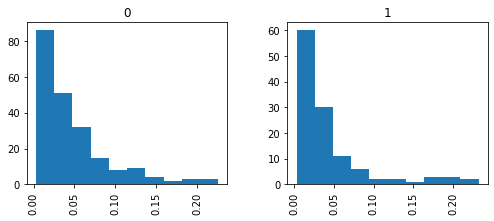

EIGENVECTOR


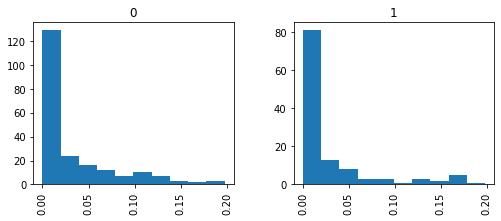

CLOSENESS_CENTRALITY


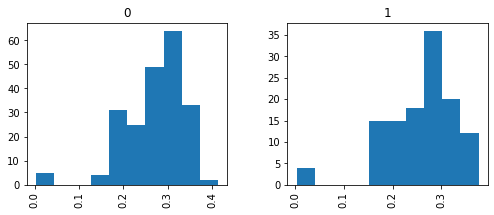

BETWEENNESS_CENTRALITY


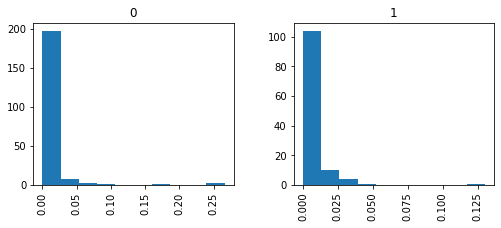

In [18]:
print('DEGREE_CENTRALITY')
summarys['DEGREE_CENTRALITY'].hist(by=summarys['GENDER'],figsize = (8,3))
plt.show()
print('EIGENVECTOR')
summarys['EIGENVECTOR'].hist(by=summarys['GENDER'],figsize = (8,3))
plt.show()
print('CLOSENESS_CENTRALITY')
summarys['CLOSENESS_CENTRALITY'].hist(by=summarys['GENDER'],figsize = (8,3))
plt.show()
print('BETWEENNESS_CENTRALITY')
summarys['BETWEENNESS_CENTRALITY'].hist(by=summarys['GENDER'],figsize = (8,3))
plt.show()

It looks like the distributions of DEGREE_CENTRALITY and EIGENVECTOR are about the same for the groups. <br>
The BETWEENNESS_CENTRALITY and CLOSENESS_CENTRALITY have slightly different in the mean value but the shapes of the distributions remain about the same.

As the mean values and graphs don't show any strong evidence of difference in the centralities of the two genders, it's time to do some hypothesis tests

### Hypothesis tests

For each of the centralities (DEGREE_CENTRALITY, EIGENVECTOR, CLOSENESS_CENTRALITY, BETWEENNESS_CENTRALITY), we performa the following Hypothesis test using t-statistic
<br><br>
Null Hypothesis: there is no significant difference in the centrality between the group Gender = 0 and the group Gender = 1 <br><br>
Alternative Hypothesis: there is a significant difference in the centrality between the group Gender = 0 and the group Gender = 1

The p-value of the tests are

In [19]:
for centrality in summarys.columns[2:-1]:
    print(centrality)
    ttest,pval = ttest_ind(summarys[centrality][summarys['GENDER'] == 0],summarys[centrality][summarys['GENDER'] == 1])
    print(pval)

DEGREE_CENTRALITY
0.4478576619702975
EIGENVECTOR
0.4125448361237033
CLOSENESS_CENTRALITY
0.08679832799079408
BETWEENNESS_CENTRALITY
0.276876807301128


### Conclusion

All p-values are more than 0.05. We can not reject the null hypothesis at the 5% significant level. <br>
We conclude that there is no significant difference in the centrality between the group Gender = 0 and the group Gender = 1 

Last, let plot our graph to view the connection of the nodes

Set up the color based on the gender

In [20]:
colors = ['Green' if g.nodes[node]['Gender'] == 1 else 'Orange'  for node in g.nodes]

draw the graph

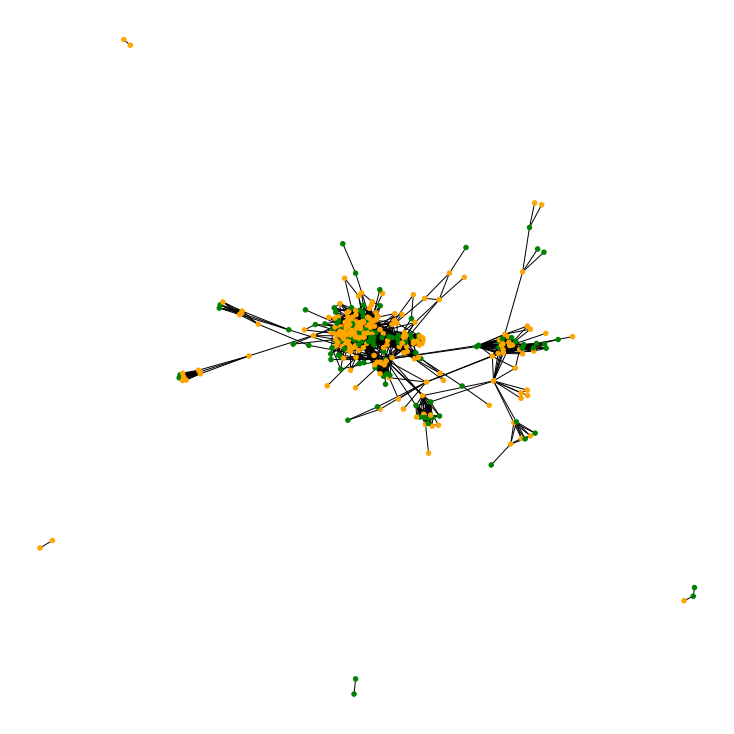

In [21]:
plt.figure(figsize=(10,10)) 
nx.draw(g, node_size = 20, node_color = colors)
plt.show()

We can see that the connections within both genders are very similar

Saving the graph as a gefx file that can be used by Gephi or other programs for visualization

In [22]:
nx.write_gexf(g, 'E:/SPS/DATA 620/assignments/facebook.gexf')